In [1]:
from __future__ import print_function
from __future__ import absolute_import

import os
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/jovyan/video-storage/amit_files/imm")

import numpy as np
import tensorflow as tf

from imm.models.imm_model import IMMModel
from imm.eval.eval_imm import load_configs
from imm.utils.plot_landmarks import plot_landmarks

In [2]:
# configuration
image_size = [128, 128] # h, w
paths_config = os.path.join('..', 'configs', 'paths', 'default.yaml')
experiment_name = 'celeba-10pts'
images_dir =  os.path.join('resources', 'visualize','first_images')

config = load_configs(
    [paths_config,
     os.path.join('..', 'configs', 'experiments', experiment_name + '.yaml')])

checkpoint_name = 'model.ckpt'
checkpoint_file = os.path.join(config.training.logdir, checkpoint_name)

In [3]:
# load images
image_files = os.listdir(images_dir)
images = []
for image_file in range(0,len(image_files)):
    image = Image.open(os.path.join(images_dir, image_files[image_file]))
    image = np.array(image.resize(image_size[::-1]), dtype=np.float32)
    images.append(image)
images = np.array(images)  # Shape: (20, 128, 128, 3)
print(images.shape)

(192, 128, 128, 3)


In [4]:
# load images
image_files = os.listdir("/home/jovyan/video-storage/amit_files/imm/examples/resources/visualize/second_images")
future_images = []
for image_file in range(0,len(image_files)):
    image = Image.open(os.path.join("/home/jovyan/video-storage/amit_files/imm/examples/resources/visualize/second_images", image_files[image_file]))
    image = np.array(image.resize(image_size[::-1]), dtype=np.float32)
    future_images.append(image)
future_images = np.array(future_images)  # Shape: (20, 128, 128, 3)
print(future_images.shape)

(192, 128, 128, 3)


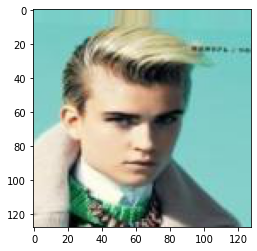

In [5]:
plt.imshow(images[0]/255.0)

In [6]:
# loaded_data = np.load("/home/jovyan/video-storage/amit_files/image_batches.npz", allow_pickle=True)
# x_list_loaded = [loaded_data['x_list'][ind] for ind in range(0,len(loaded_data["x_list"]),5)]
# x_dash_list_loaded = [loaded_data['x_dash_list'][ind] for ind in range(0,len(loaded_data["x_dash_list"]),5)]

# img_array = np.stack(x_list_loaded,axis=0)
# future_array = np.stack(x_dash_list_loaded,axis = 0)
# print(img_array.shape)
# print(future_array.shape)

# img_array = img_array.reshape(-1,3,128,128)
# future_array = future_array.reshape(-1,3,128,128)
# print(img_array.shape)
# print(future_array.shape)

# img_array = np.transpose(img_array,(0,2,3,1))
# future_array = np.transpose(future_array,(0,2,3,1))
# print(img_array.shape)
# print(future_array.shape)

In [7]:
# # Create folder to save images
# output_folder = 'third_images'
# os.makedirs(output_folder, exist_ok=True)

# # Save images
# for i, img_array in enumerate(future_array):
#     # Scale values from [0, 1] to [0, 255]
#     img_array = (img_array * 255).astype(np.uint8)
#     img = Image.fromarray(img_array)

#     # Save image as .jpg
#     img.save(os.path.join(output_folder, f'predicted_{i + 1}.jpg'))

# print(f"Saved {len(future_array)} images to '{output_folder}'")


In [8]:
# with tf.Graph().as_default() as graph:
#     # set up dataset
#     dataset = tf.data.Dataset.from_tensors({'image': images, 'future_image': images})
#     iterator = dataset.make_one_shot_iterator()
#     inputs = iterator.get_next()
    
#     # set up model
#     training_pl = False
#     net_instance = IMMModel(config.model)
#     _, _, _, tensors = net_instance.build(
#         inputs, training_pl=training_pl, output_tensors=True, build_loss=False)
    
#     # start a new session
#     session_config = tf.ConfigProto(allow_soft_placement=True,
#                                     log_device_placement=False)
#     session_config.gpu_options.allow_growth = True
#     with tf.Session(config=session_config) as session:
#         global_init = tf.global_variables_initializer()
#         local_init = tf.local_variables_initializer()
#         session.run([global_init, local_init])

#         # restore checkpoint
#         if tf.gfile.Exists(checkpoint_file) or tf.gfile.Exists(checkpoint_file + '.index'):
#             reader = tf.train.NewCheckpointReader(checkpoint_file)
#             vars_to_restore = tf.global_variables()
#             checkpoint_vars = reader.get_variable_to_shape_map().keys()
#             vars_ignored = [
#                 v.name for v in vars_to_restore if v.name[:-2] not in checkpoint_vars]
#             if vars_ignored:
#                 print('vars-IGNORED (not restoring)')
#                 print(', '.join(vars_ignored))
#             vars_to_restore = [
#                 v for v in vars_to_restore if v.name[:-2] in checkpoint_vars]
#             restorer = tf.train.Saver(var_list=vars_to_restore)
#             restorer.restore(session, checkpoint_file)
#         else:
#             raise Exception('model file does not exist at: ' + checkpoint_file)

#         # evaluate model
#         landmarks = session.run(tensors['gauss_yx'])    

In [9]:
# Ensure tensors are evaluated in the same session
with tf.Graph().as_default() as graph:
    # Set up dataset
    dataset = tf.data.Dataset.from_tensors({'image': future_images, 'future_image': images})
    iterator = dataset.make_one_shot_iterator()
    inputs = iterator.get_next()

    # Set up model
    training_pl = False
    net_instance = IMMModel(config.model)
    _, _, _, tensors = net_instance.build(
        inputs, training_pl=training_pl, output_tensors=True, build_loss=False)

    session_config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    session_config.gpu_options.allow_growth = True

    with tf.Session(config=session_config) as session:
        session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

        # Restore checkpoint
        if tf.gfile.Exists(checkpoint_file) or tf.gfile.Exists(checkpoint_file + '.index'):
            reader = tf.train.NewCheckpointReader(checkpoint_file)
            vars_to_restore = [v for v in tf.global_variables() if v.name[:-2] in reader.get_variable_to_shape_map()]
            tf.train.Saver(var_list=vars_to_restore).restore(session, checkpoint_file)
        else:
            raise Exception('Model file does not exist at: ' + checkpoint_file)

        # Evaluate tensors
        input_img, future_img, predicted_img, landmarks, pose_embedding = session.run([
            inputs['image'], inputs['future_image'], tensors['future_im_pred'], tensors['gauss_yx'], tensors['pose_embedding']
        ])

        # Ensure pixel values are in [0, 255] range and convert to uint8
        input_image = np.clip(input_img, 0, 255).astype(np.uint8)
        future_image = np.clip(future_img, 0, 255).astype(np.uint8)
        predicted_image = np.clip(predicted_img, 0, 255).astype(np.uint8)

        # # Plot input, future, and predicted images with landmarks
        # num_images = input_image.shape[0]
        # fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

        # for i in range(num_images):
        #     # Handle case where there is only one image
        #     if num_images == 1:
        #         axs = [axs]

        #     # Original input image (Column 1)
        #     axs[i][0].imshow(future_image[i])
        #     axs[i][0].axis('off')
        #     axs[i][0].set_title(f'Input Image {i + 1}')

        #     # Future image (Column 2)
        #     axs[i][1].imshow(input_image[i])
        #     axs[i][1].axis('off')
        #     axs[i][1].set_title(f'Future Image {i + 1}')

        #     # Predicted image with landmarks (Column 3)
        #     axs[i][2].imshow(predicted_image[i])
        #     plot_landmarks(axs[i][2], landmarks[i], size=2.5)  # Overlay landmarks
        #     axs[i][2].axis('off')
        #     axs[i][2].set_title(f'Predicted Image {i + 1}')

        # plt.tight_layout()
        # plt.show()


INFO:tensorflow:Restoring parameters from /home/jovyan/video-storage/amit_files/imm/checkpoints//celeba-10pts/model.ckpt


In [10]:
# denormalize landmarks
landmarks = ((landmarks + 1) / 2.0) * np.array(image_size)
print(landmarks.shape)

(192, 10, 2)


In [11]:
print(predicted_image.shape)
print(np.unique(predicted_image[0]))

(192, 128, 128, 3)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241

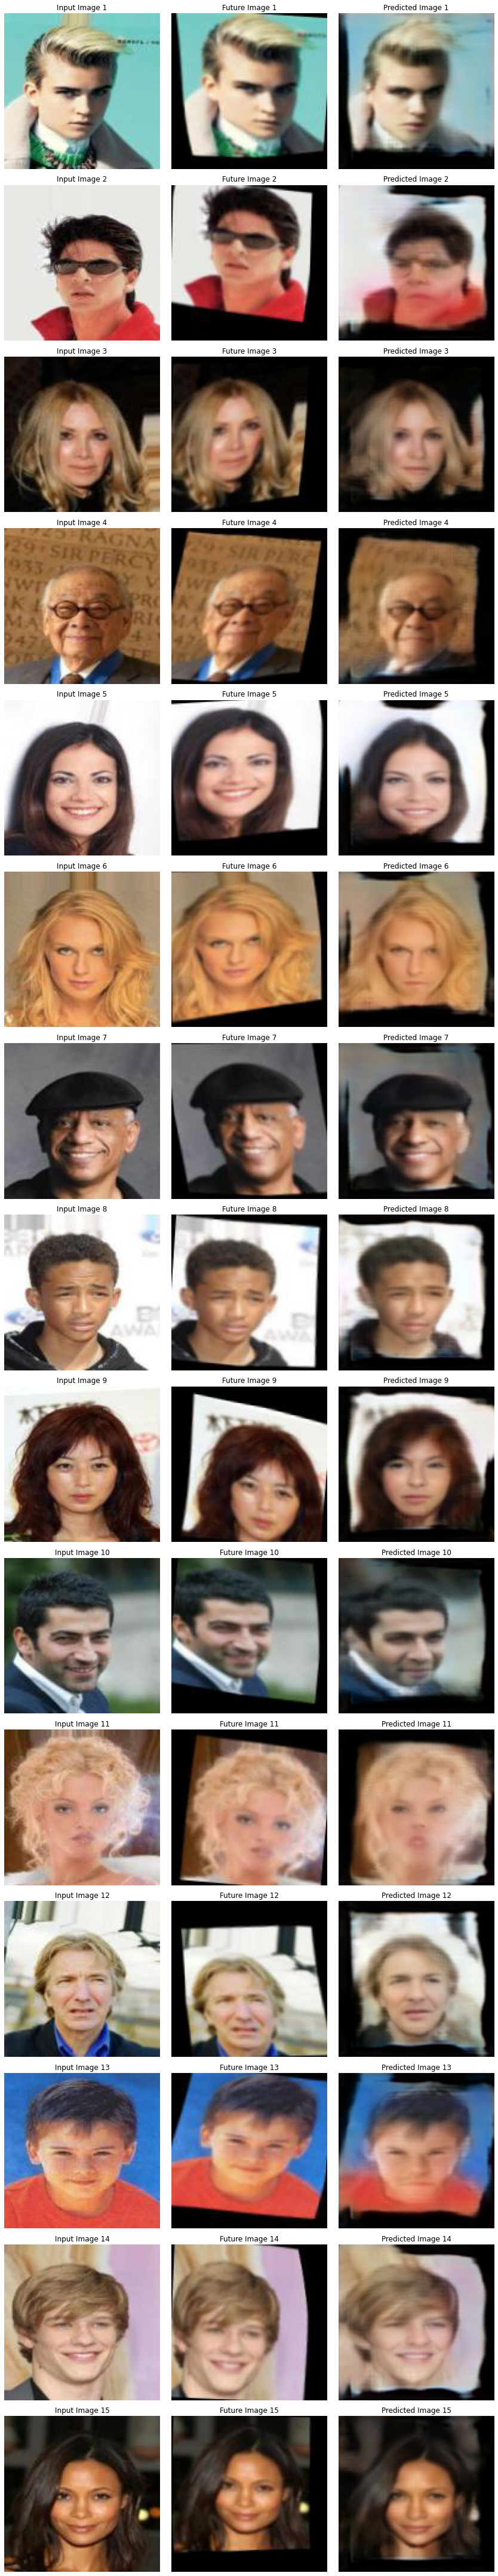

In [13]:
# Ensure pixel values are in [0, 255] and convert to uint8
# input_image = np.clip(input_image, 0, 255).astype(np.uint8)
# future_image = np.clip(future_image, 0, 255).astype(np.uint8)
# predicted_image = np.clip(predicted_image, 0, 255).astype(np.uint8)

# Number of images
# num_images = input_image.shape[0]
num_images = 15

# Create a grid: Rows for each image, 3 columns for input, future, predicted
fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

for i in range(num_images):
    # Input Image (Column 1)
    axs[i, 0].imshow(future_image[i])
    axs[i, 0].set_title(f"Input Image {i + 1}")
    axs[i, 0].axis('off')

    # Future Image (Column 2)
    axs[i, 1].imshow(input_image[i])
    axs[i, 1].set_title(f"Future Image {i + 1}")
    axs[i, 1].axis('off')

    # Predicted Image with Landmarks (Column 3)
    axs[i, 2].imshow(predicted_image[i])
    # plot_landmarks(axs[i, 2], landmarks[i], size=2.5)  # Overlay landmarks
    axs[i, 2].set_title(f"Predicted Image {i + 1}")
    axs[i, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

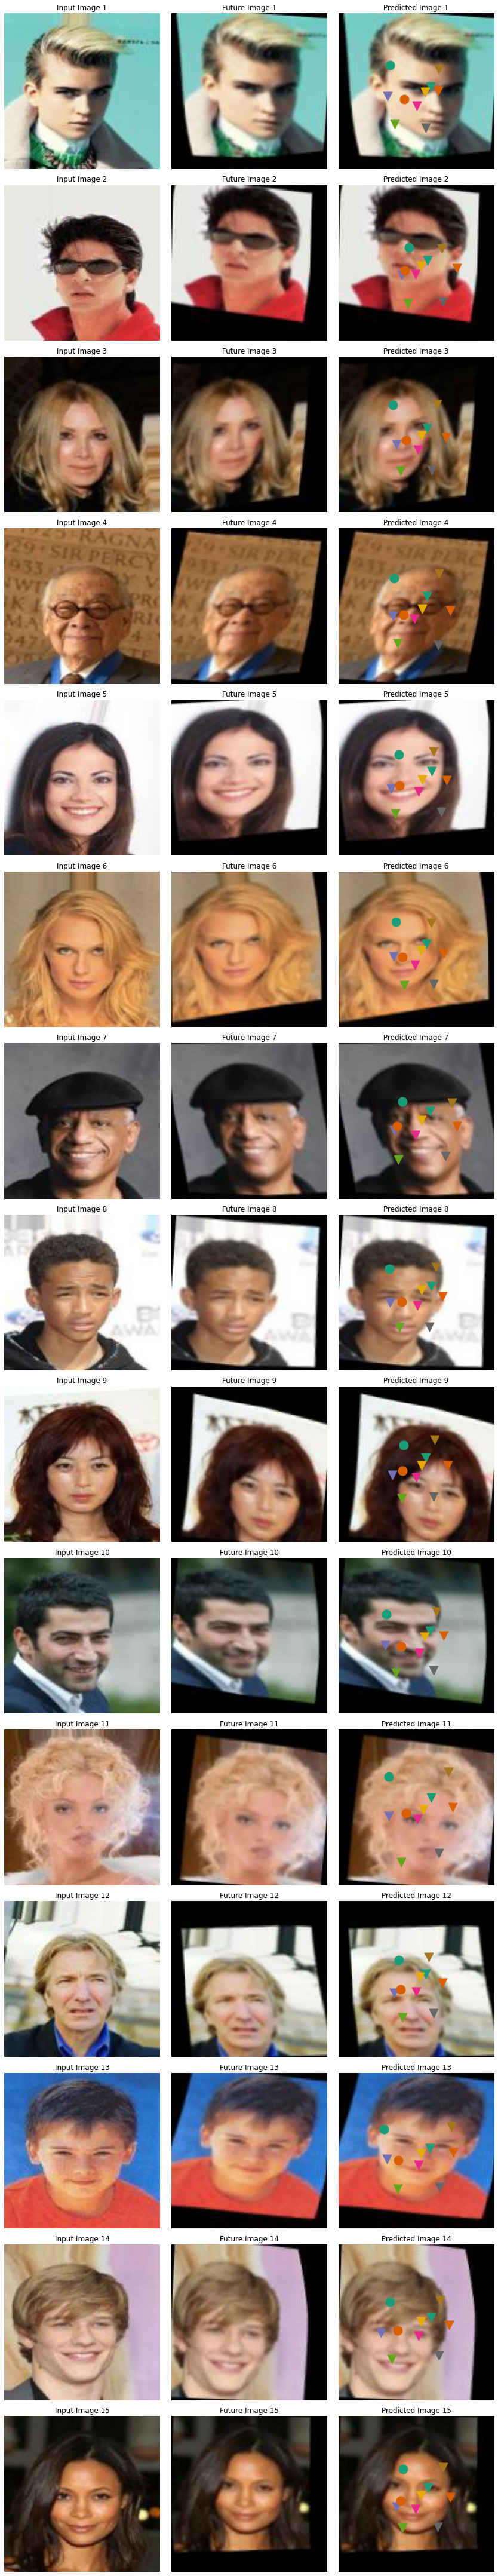

In [14]:
# Ensure pixel values are in [0, 255] and convert to uint8
# input_image = np.clip(input_image, 0, 255).astype(np.uint8)
# future_image = np.clip(future_image, 0, 255).astype(np.uint8)
# predicted_image = np.clip(predicted_image, 0, 255).astype(np.uint8)

# Number of images
# num_images = input_image.shape[0]
num_images = 15

# Create a grid: Rows for each image, 3 columns for input, future, predicted
fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

for i in range(num_images):
    # Input Image (Column 1)
    axs[i, 0].imshow(future_image[i])
    axs[i, 0].set_title(f"Input Image {i + 1}")
    axs[i, 0].axis('off')

    # Future Image (Column 2)
    axs[i, 1].imshow(input_image[i])
    axs[i, 1].set_title(f"Future Image {i + 1}")
    axs[i, 1].axis('off')

    # Predicted Image with Landmarks (Column 3)
    axs[i, 2].imshow(input_image[i])
    plot_landmarks(axs[i, 2], landmarks[i], size=2.5)  # Overlay landmarks
    axs[i, 2].set_title(f"Predicted Image {i + 1}")
    axs[i, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


# Calculate PSNR

In [32]:
def calculate_psnr(img1, img2):
    """Compute PSNR between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # Infinite PSNR if images are identical
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

# Compute PSNR for each image in the batch
psnr_values = [calculate_psnr(predicted_image[i], input_image[i]) for i in range(len(predicted_image))]

# Print PSNR values
for i, psnr in enumerate(psnr_values):
    print(f"PSNR for Image {i + 1}: {psnr:.2f} dB")

# Average PSNR across the batch
average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr:.2f} dB")


PSNR for Image 1: 28.53 dB
PSNR for Image 2: 28.97 dB
PSNR for Image 3: 29.34 dB
PSNR for Image 4: 29.42 dB
PSNR for Image 5: 29.12 dB
PSNR for Image 6: 28.87 dB
PSNR for Image 7: 29.44 dB
PSNR for Image 8: 29.00 dB
PSNR for Image 9: 28.52 dB
PSNR for Image 10: 28.90 dB
PSNR for Image 11: 29.21 dB
PSNR for Image 12: 28.74 dB
PSNR for Image 13: 28.80 dB
PSNR for Image 14: 28.66 dB
PSNR for Image 15: 29.47 dB
PSNR for Image 16: 29.13 dB
PSNR for Image 17: 28.81 dB
PSNR for Image 18: 29.77 dB
PSNR for Image 19: 29.26 dB
PSNR for Image 20: 28.71 dB
PSNR for Image 21: 29.17 dB
PSNR for Image 22: 29.66 dB
PSNR for Image 23: 29.72 dB
PSNR for Image 24: 28.72 dB
PSNR for Image 25: 28.89 dB
PSNR for Image 26: 28.77 dB
PSNR for Image 27: 29.22 dB
PSNR for Image 28: 29.24 dB
PSNR for Image 29: 29.12 dB
PSNR for Image 30: 29.04 dB
PSNR for Image 31: 28.30 dB
PSNR for Image 32: 29.23 dB
PSNR for Image 33: 28.59 dB
PSNR for Image 34: 29.25 dB
PSNR for Image 35: 29.52 dB
PSNR for Image 36: 28.79 dB
P

# Calculate SSIM

In [34]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(img1, img2):
    """Compute SSIM between two images."""
    return ssim(img1, img2, multichannel=True, data_range=255)

# Compute SSIM for each image in the batch
ssim_values = [calculate_ssim(predicted_image[i], future_image[i]) for i in range(len(predicted_image))]

# Print SSIM values
for i, ssim_val in enumerate(ssim_values):
    print(f"SSIM for Image {i + 1}: {ssim_val:.4f}")

# Average SSIM across the batch
average_ssim = np.mean(ssim_values)
print(f"Average SSIM: {average_ssim:.4f}")


SSIM for Image 1: 0.5205
SSIM for Image 2: 0.3779
SSIM for Image 3: 0.5532
SSIM for Image 4: 0.3282
SSIM for Image 5: 0.5370
SSIM for Image 6: 0.3905
SSIM for Image 7: 0.5766
SSIM for Image 8: 0.4727
SSIM for Image 9: 0.3529
SSIM for Image 10: 0.4329
SSIM for Image 11: 0.3185
SSIM for Image 12: 0.3584
SSIM for Image 13: 0.4235
SSIM for Image 14: 0.4847
SSIM for Image 15: 0.6103
SSIM for Image 16: 0.5515
SSIM for Image 17: 0.5324
SSIM for Image 18: 0.6581
SSIM for Image 19: 0.4620
SSIM for Image 20: 0.3687
SSIM for Image 21: 0.4683
SSIM for Image 22: 0.4157
SSIM for Image 23: 0.5860
SSIM for Image 24: 0.3968
SSIM for Image 25: 0.5208
SSIM for Image 26: 0.3700
SSIM for Image 27: 0.3739
SSIM for Image 28: 0.4869
SSIM for Image 29: 0.4604
SSIM for Image 30: 0.4497
SSIM for Image 31: 0.2219
SSIM for Image 32: 0.4270
SSIM for Image 33: 0.1895
SSIM for Image 34: 0.3933
SSIM for Image 35: 0.4640
SSIM for Image 36: 0.4514
SSIM for Image 37: 0.4771
SSIM for Image 38: 0.5699
SSIM for Image 39: 0.

In [14]:
# # plot unsupervised landmarks
# cols = min(4, len(images))
# rows = int(np.ceil(len(images) / float(cols)))
# fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
# for i, ax in enumerate(np.ravel(axs)):
#     if i < len(images):
#         ax.imshow(images[i].astype(np.uint8))
#         plot_landmarks(ax, landmarks[i], size=2.5)
#     plt.tight_layout()
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
#     ax.set_axis_off()

# Calculate BRISQUE

In [15]:
pip install numpy==1.19.5 scipy==1.5.4 pillow==6.2.2

     |████████████████████████████████| 14.8 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 30.5 MB/s eta 0:00:01
ERROR: tensorflow 1.10.0 has requirement numpy<=1.14.5,>=1.13.3, but you'll have numpy 1.19.5 which is incompatible.
ERROR: imageio 2.15.0 has requirement pillow>=8.3.2, but you'll have pillow 6.2.2 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
Note: you may need to restart the kernel to use updated packages.


In [35]:
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import kurtosis, skew

# Compute MSCN coefficients
def compute_mscn(img, sigma=7, const=1e-5):
    mu = gaussian_filter(img, sigma, mode='reflect')
    sigma = np.sqrt(gaussian_filter(img**2, sigma, mode='reflect') - mu**2)
    return (img - mu) / (sigma + const)

# Extract Natural Scene Statistics (NSS) features
def extract_nss_features(img):
    mscn = compute_mscn(img)

    # Pairwise product coefficients (for better quality assessment)
    left = np.roll(mscn, 1, axis=1)
    right = np.roll(mscn, -1, axis=1)
    up = np.roll(mscn, 1, axis=0)
    down = np.roll(mscn, -1, axis=0)
    diag1 = np.roll(np.roll(mscn, 1, axis=0), 1, axis=1)
    diag2 = np.roll(np.roll(mscn, -1, axis=0), -1, axis=1)

    features = [
        np.mean(mscn), np.var(mscn), skew(mscn.flatten()), kurtosis(mscn.flatten()),
        np.mean(left * mscn), np.mean(right * mscn),
        np.mean(up * mscn), np.mean(down * mscn),
        np.mean(diag1 * mscn), np.mean(diag2 * mscn)
    ]
    return features

# Calculate BRISQUE proxy score
def calculate_brisque_batch(image_batch):
    scores = []
    for img in image_batch:
        # Convert RGB to grayscale using luminance (ITU-R BT.601 standard)
        grayscale_img = 0.2989 * img[:, :, 0] + 0.5870 * img[:, :, 1] + 0.1140 * img[:, :, 2]

        # Extract features and compute BRISQUE proxy
        features = extract_nss_features(grayscale_img)

        # Use L2 norm and scale to approximate BRISQUE (0-100 range)
        score = np.linalg.norm(features) * 50
        scores.append(score)

    return np.array(scores)



# Calculate BRISQUE proxy scores
brisque_scores = calculate_brisque_batch(predicted_image)

# Print individual scores and average
for i, score in enumerate(brisque_scores):
    print(f"Image {i + 1}: BRISQUE Proxy Score = {score:.2f}")

average_score = np.mean(brisque_scores)
print(f"\nAverage BRISQUE Proxy Score: {average_score:.2f}")


Image 1: BRISQUE Proxy Score = 66.48
Image 2: BRISQUE Proxy Score = 48.89
Image 3: BRISQUE Proxy Score = 73.31
Image 4: BRISQUE Proxy Score = 48.20
Image 5: BRISQUE Proxy Score = 47.48
Image 6: BRISQUE Proxy Score = 65.05
Image 7: BRISQUE Proxy Score = 57.00
Image 8: BRISQUE Proxy Score = 69.33
Image 9: BRISQUE Proxy Score = 61.51
Image 10: BRISQUE Proxy Score = 55.12
Image 11: BRISQUE Proxy Score = 56.72
Image 12: BRISQUE Proxy Score = 58.20
Image 13: BRISQUE Proxy Score = 47.28
Image 14: BRISQUE Proxy Score = 55.50
Image 15: BRISQUE Proxy Score = 55.11
Image 16: BRISQUE Proxy Score = 63.50
Image 17: BRISQUE Proxy Score = 78.58
Image 18: BRISQUE Proxy Score = 113.39
Image 19: BRISQUE Proxy Score = 72.36
Image 20: BRISQUE Proxy Score = 60.04
Image 21: BRISQUE Proxy Score = 62.54
Image 22: BRISQUE Proxy Score = 44.56
Image 23: BRISQUE Proxy Score = 66.88
Image 24: BRISQUE Proxy Score = 57.74
Image 25: BRISQUE Proxy Score = 55.35
Image 26: BRISQUE Proxy Score = 64.89
Image 27: BRISQUE Pr